In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import datetime

In [2]:
mypath = r"Stats"
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

In [10]:
df = pd.read_csv(os.path.join(mypath, onlyfiles[-1]))

#preprocess gametime

t = np.array(df["Time"], )
t = t.astype(datetime)

t = np.array([datetime.strptime(my_date_string, '%Y-%m-%d %H:%M:%S.%f') for my_date_string in t])

start_time = t[0]
t = t - start_time

t = np.array([int(timesince.total_seconds()) for timesince in t]) 
df["GameTime"] = t
df

,Unnamed: 0,Player,Profile,Time,Event,GameTime
0,0,test,profile1,2022-07-28 21:27:28.032968,LevelLoad,0
1,1,test,profile1,2022-07-28 21:27:28.034969,killed an enemy,0
2,2,test,profile1,2022-07-28 21:28:00.378776,hp 460,32
3,3,test,profile1,2022-07-28 21:28:00.380777,armor 26,32
4,4,test,profile1,2022-07-28 21:28:00.386778,shielded hit,32
...,...,...,...,...,...,...
188,188,test,profile1,2022-07-28 21:28:54.606411,armor 0,86
189,189,test,profile1,2022-07-28 21:28:54.610413,downed,86
190,190,test,profile1,2022-07-28 21:28:54.614413,hp 0,86
191,191,test,profile1,2022-07-28 21:28:54.616415,armor 0,86


enemies killed 1


Text(0.5, 0, 'Time')

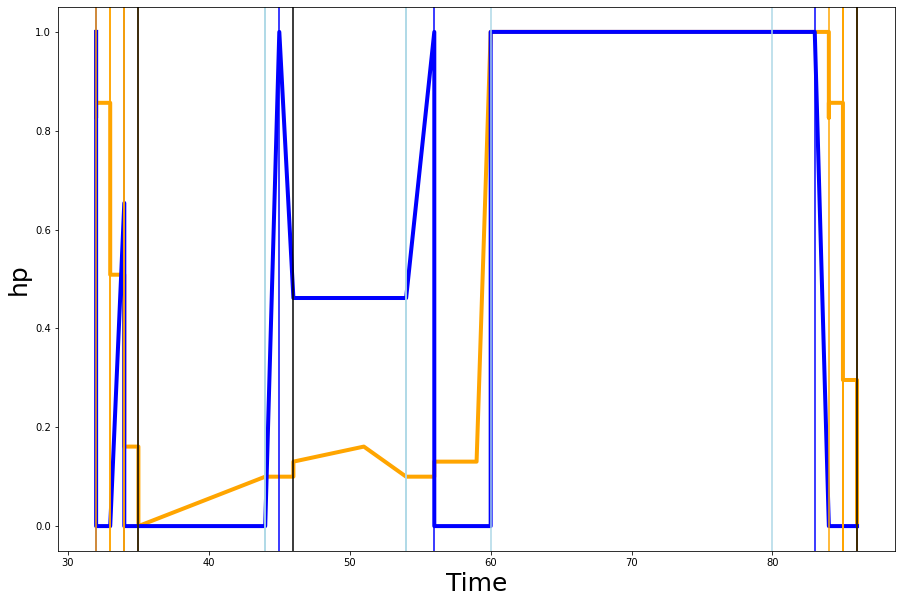

In [63]:
fig, ax=plt.subplots(figsize=(15,10))

#killed enemies
df_deaths_enemy = df.loc[df["Event"].str.contains("killed an enemy", case = False)]
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='black')


print(f"enemies killed", len(df_deaths_enemy["GameTime"]))

# player hp
df_hp = df.loc[df["Event"].str.contains("hp", case = False)]
hp = np.array([int(ev.replace("hp ","")) for ev in df_hp["Event"]])
hp_max = np.max(hp)
hp = hp/hp_max
ax.plot(df_hp["GameTime"], hp, label="hp", linewidth=4.0, color='orange')

# player armor
df_hp = df.loc[df["Event"].str.contains("armor", case = False)]
df_hp = df_hp.loc[~df_hp["Event"].str.contains("regenerate armor", case = False)]
armor = np.array([int(ev.replace("armor ","")) for ev in df_hp["Event"]])
armor_max = np.max(armor)
ax.plot(df_hp["GameTime"], armor/armor_max, label="armor", linewidth=4.0, color='blue')


#player take damage
df_deaths_enemy = df.loc[df["Event"]=="shielded hit"]
for t in df_deaths_enemy["GameTime"]:
    ax.axvline(x=t, color = "blue")
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='blue')

df_deaths_enemy = df.loc[df["Event"]=="unshielded hit"]
for t in df_deaths_enemy["GameTime"]:
    ax.axvline(x=t, color = "orange")
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='orange')

df_deaths_enemy = df.loc[df["Event"]=="auto regenerate armor"]
for t in df_deaths_enemy["GameTime"]:
    ax.axvline(x=t,color = "lightblue")
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='blue')

df_deaths_enemy = df.loc[df["Event"]=="revived by ally"]
for t in df_deaths_enemy["GameTime"]:
    ax.axvline(x=t,color = "lightblue")
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='lightblue')

df_deaths_enemy = df.loc[df["Event"]=="downed"]
for t in df_deaths_enemy["GameTime"]:
    ax.axvline(x=t, color = "black")
#ax.scatter(df_deaths_enemy["GameTime"], np.arange(1,len(df_deaths_enemy["Time"])+1), label="Enemies killed", linewidth=2.0, color='black')

#ax.plot(x,y, linewidth=10.0, color='black', label="Average", zorder=2)
ax.set_ylabel(f"hp", fontsize=25)
ax.set_xlabel(f"Time", fontsize=25)